Денис Иванов

Домашнее задание:  Задачи классификации

In [26]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import io
import requests
import ssl

1. Загрузить датасет

In [27]:
ssl._create_default_https_context = ssl._create_unverified_context
url="http://yustiks.ru/dataset/creditcard.csv"
dataset=pd.read_csv(url)
dataset.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
# Выявляем выбросы по старинке
amount_group = pd.cut(dataset['Amount'], [-0.01, 0.01, 1,  90, 1200,  99999]) 
table = pd.pivot_table(dataset, 
                       values =['V22'], 
                       index = amount_group, 
                       columns = ['Class'], 
                       aggfunc = 'count') 
table.columns = ['clear', 'defolt']
table['bad_rate']= 100 * table['defolt']/(table['clear']+table['defolt'])
table

,clear,defolt,bad_rate
Amount,,,
"(-0.01, 0.01]",2511,32,1.258356
"(0.01, 1.0]",27800,149,0.533114
"(1.0, 90.0]",191828,147,0.076572
"(90.0, 1200.0]",60083,156,0.258968
"(1200.0, 99999.0]",2093,8,0.380771


In [5]:
# Удаляем выбросы:
# Удаляем столбец Time,  ибо судя по содержанию столбца - это период времени 
# (в секундах или минутах) с начала наблюдений,  но не отметка о времени события.
# (в моем понимании: в кредитном скоринге время информативно только если это timestamp, 
# который можно првязать к времени суток (части рабочего дня), дням недели или 
# или графику работы сотрудников - иначе 
# абстрактный период времени от точки в прошлом которую мы не знаем, есть - шумы, имхо)

ds= dataset[(dataset['Amount'] > 0.01)&(dataset['Amount'] < 1200)].iloc[:, 1:31]
print('Отбросили ', len(dataset) - len(ds), 'наблюдений, что составило', 
      100* (len(dataset) - len(ds)) / len(dataset), '% выборки') 


Отбросили  4669 наблюдений, что составило 1.6393557742611664 % выборки


2. Посмотреть отсутствующие значения (какое количество Nan элементов).

In [6]:
print('В датасете отсутствуют значения по следующим полям: \n', ds.isna().sum())
print('Итого в датасете отсутствуют:', ds.isna().sum().sum(), 'значений')

В датасете отсутствуют значения по следующим полям: 
 V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64
Итого в датасете отсутствуют: 0 значений


3. Основное таргет значение: 1 - сделка была обманной, 0 - честной. 
Сделать график barplot для этих двух классов из колонки 'Class'. 
Посчитать количество элементов в классе 1 и в классе 2.

In [7]:
print('Количество дефолтов       =', np.sum(ds.Class==1))
print('Количество честных сделок =', np.sum(ds.Class==0))
print('Доля дефолтов по колич-ву =', 100 * np.sum(ds.Class==1) / ds.shape[0], 'процентов')

Количество дефолтов       = 452
Количество честных сделок = 279686
Доля дефолтов по колич-ву = 0.16134904939708286 процентов


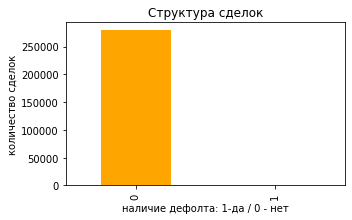

In [8]:
ds['Class'].value_counts(dropna = False).plot.bar(color = 'orange', figsize = (5, 3))

plt.title('Структура сделок')
plt.xlabel('наличие дефолта: 1-да / 0 - нет')
plt.ylabel('количество сделок')
plt.show()

4. Сколько денег было использовано в обманных операциях, 
а сколько - в нормальных операциях? 
Сделать частотный график по колонке Amount для колонки Class 
по двум независимым выборкам: обманная операция, нормальная операция

In [9]:
ds_fraud = ds[ds['Class'] == 1].Amount
ds_clear = ds[ds['Class'] == 0].Amount

print('Сумма дефолтов         =', ds_fraud.sum())
print('Сумма честных сделок   =', ds_clear.sum())
print('Доля дефолтов по сумме =', ds_fraud.sum() * 100 /
                                  (ds_clear.sum()+ ds_fraud.sum()),
                                   'процентов')
print('в среднем по выборке крупные кредиты чаще в дефолте (0,16 < 0,23)')

Сумма дефолтов         = 47987.58
Сумма честных сделок   = 20690693.04
Доля дефолтов по сумме = 0.23139167278424488 процентов
в среднем по выборке крупные кредиты чаще в дефолте (0,16 < 0,23)


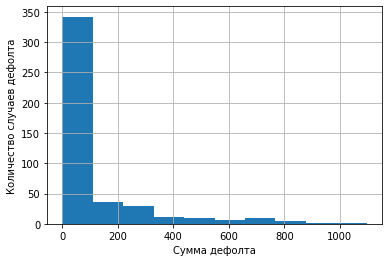

In [10]:
plt.xlabel('Сумма дефолта')
plt.ylabel('Количество случаев дефолта')
ds_fraud.hist()
plt.show()

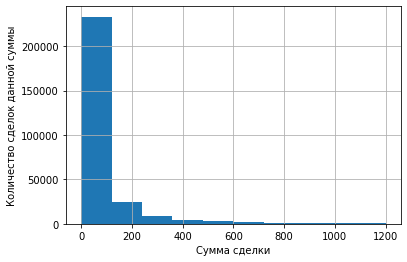

In [11]:
plt.xlabel('Сумма сделки')
plt.ylabel('Количество сделок данной суммы')
ds_clear.hist()
plt.show()

5. Построить графики histograms для всех значений

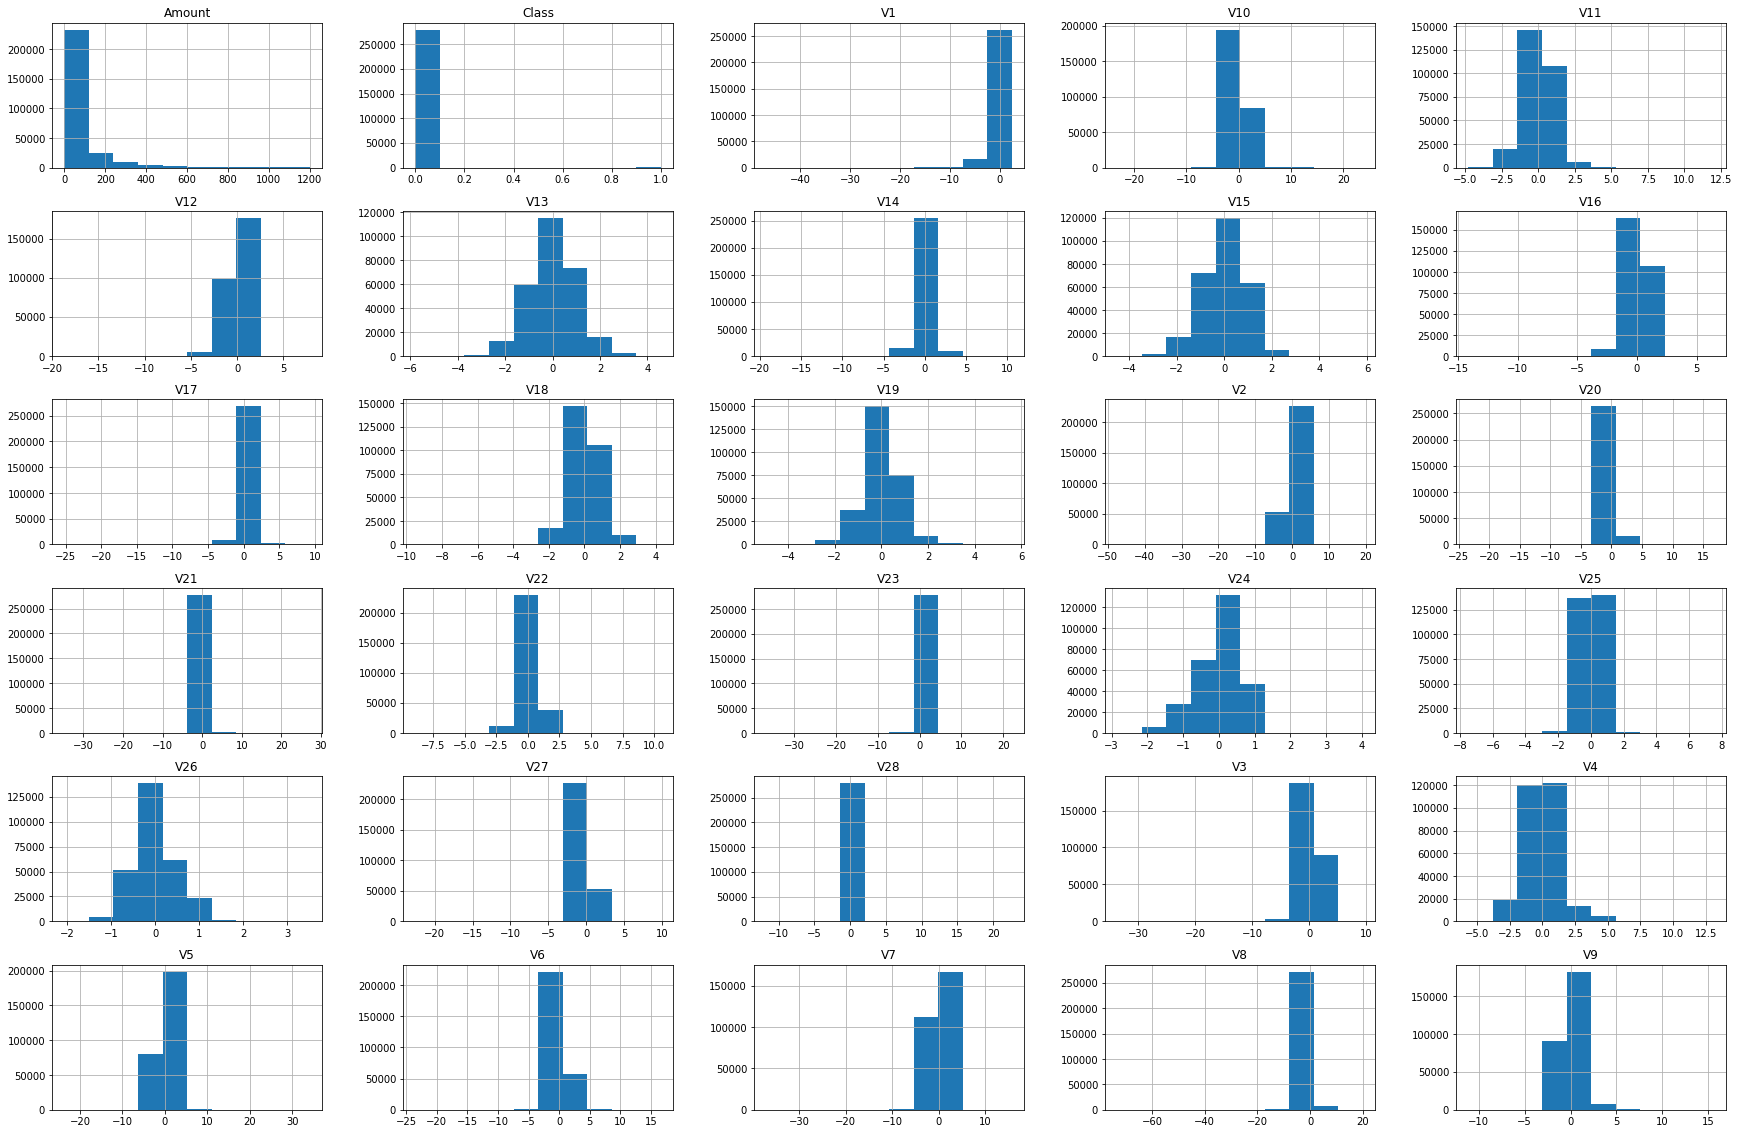

In [12]:
ds.hist(figsize=(30,20))
plt.show()

6. Построить матрицу корреляций для всех значений

          V1    V2    V3    V4    V5    V6    V7    V8    V9   V10  ...   V21  \
V1      1.00 -0.13 -0.05  0.04 -0.06  0.03  0.08 -0.03  0.00 -0.01  ... -0.00   
V2     -0.13  1.00 -0.09  0.06 -0.09  0.04  0.15 -0.03 -0.00 -0.03  ...  0.04   
V3     -0.05 -0.09  1.00  0.02 -0.08  0.04  0.09 -0.03 -0.01 -0.02  ...  0.00   
V4      0.04  0.06  0.02  1.00  0.03 -0.02 -0.03  0.01  0.01  0.00  ... -0.00   
V5     -0.06 -0.09 -0.08  0.03  1.00  0.12  0.22 -0.05 -0.01 -0.04  ... -0.01   
V6      0.03  0.04  0.04 -0.02  0.12  1.00 -0.14  0.03  0.01  0.02  ...  0.01   
V7      0.08  0.15  0.09 -0.03  0.22 -0.14  1.00  0.04  0.01  0.04  ... -0.01   
V8     -0.03 -0.03 -0.03  0.01 -0.05  0.03  0.04  1.00 -0.00 -0.01  ... -0.01   
V9      0.00 -0.00 -0.01  0.01 -0.01  0.01  0.01 -0.00  1.00 -0.01  ...  0.01   
V10    -0.01 -0.03 -0.02  0.00 -0.04  0.02  0.04 -0.01 -0.01  1.00  ...  0.01   
V11     0.01  0.00  0.01  0.00  0.01 -0.00 -0.01  0.00 -0.00  0.00  ...  0.00   
V12    -0.00  0.00 -0.01  0.

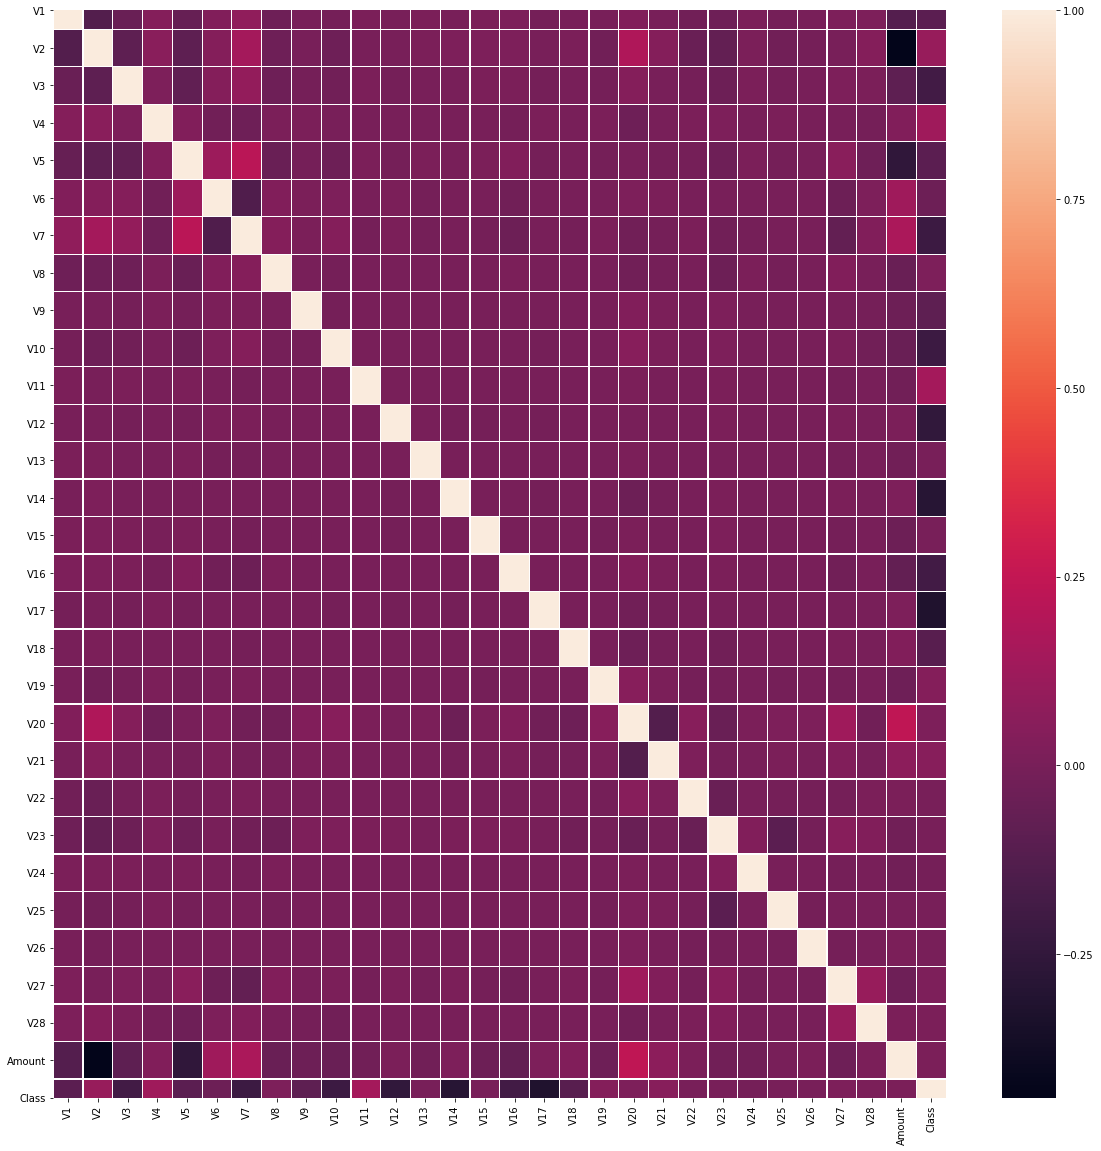

In [13]:
plt.subplots(figsize=(20, 20))
m_corr = np.round_(ds.corr(), decimals=2)
print(m_corr)
sns.heatmap(m_corr, linewidths=0.2)

7-8. 
Взять все имеющиеся атрибуты из таблицы для предсказания. 
Разделить на тренировочные и тестовые. Написать модель деревья решений. 
Сделать classification report.

Нормализовать данные и написать модель Random Forest уже на нормализованных данных. Сделать classification report. Сравнить с результатом, полученном в задаче 7. Нужно ли нормализовывать данные?

In [14]:
# Нормализуем параметры датасета / в части независимых переменных - сначала решаем задачу 8

headers = list(ds.iloc[:,:28].columns.values)
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
ds_scaled = min_max_scaler.fit_transform(ds.iloc[:,:28])
ds_norm = pd.DataFrame(ds_scaled)
ds_norm.columns = headers
ds_norm.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,0.845275,0.422195,0.682041,-0.249287,-0.192252,0.194647,0.414965,0.572888,-0.139991,-0.007138,...,0.014133,0.178376,0.122369,-0.054688,0.244453,-0.153420,0.015533,-0.327076,0.399219,-0.318991
1,0.948770,0.432373,0.571978,-0.348158,-0.178461,0.167485,0.402886,0.572597,-0.186337,-0.018113,...,-0.090340,0.162422,0.115680,-0.149221,0.251662,-0.272022,0.020678,-0.214289,0.390433,-0.316907
2,0.845334,0.384134,0.646599,-0.355427,-0.197960,0.261368,0.435900,0.576085,-0.280585,-0.002163,...,-0.492456,0.191994,0.130955,-0.003750,0.279173,-0.373905,-0.045229,-0.309167,0.387574,-0.321246
3,0.861237,0.418818,0.647518,-0.487582,-0.180896,0.233779,0.414889,0.578868,-0.271032,-0.013343,...,-0.296871,0.155505,0.119467,-0.082801,0.241735,-0.515693,0.084640,-0.338825,0.394853,-0.314185
4,0.853451,0.450740,0.636173,-0.352955,-0.194637,0.176374,0.428369,0.564967,-0.106015,0.021060,...,0.090049,0.186198,0.122655,-0.001006,0.243534,-0.131745,-0.029028,-0.079522,0.404512,-0.305231


In [20]:
#  тест на мультиколлениарность - по лекционному ноутбуку - что то не то
corr_matrix = ds_norm.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Показатель мультиколлениарности в ноутбуке (>0.95)- преступно высок, , берем реальные цифры
to_drop = [column for column in upper.columns if any(upper[column] > 0.3)]
print(to_drop)

# вижу ошибку, смотрите:
print(upper.head(3))
to_think = [min(upper[column]) for column in upper.columns]
to_think[2]
# минимальный показатель коллинеарности по V3 не может быть 0.051

# для получения ответа нужно обращаться ко всей матрице корреляций, а не к треугольнику
to_drop_2 = [column for column in corr_matrix.columns if all (corr_matrix[column] < 0.3)]
if  len(to_drop_2) > 0:
    print (to_drop_2)
else:
    print('Nothing to drop')

[]
    V1        V2        V3        V4        V5        V6        V7        V8  \
V1 NaN  0.128169  0.051747  0.035820  0.060428  0.032531  0.083710  0.028847   
V2 NaN       NaN  0.091298  0.061438  0.088489  0.038327  0.145719  0.025175   
V3 NaN       NaN       NaN  0.020371  0.075588  0.040057  0.093416  0.028323   

          V9       V10  ...       V19       V20       V21       V22       V23  \
V1  0.004233  0.013843  ...  0.003642  0.030590  0.002819  0.018142  0.033739   
V2  0.001363  0.028132  ...  0.021888  0.175889  0.043018  0.047288  0.068415   
V3  0.008781  0.020024  ...  0.005636  0.035131  0.002691  0.012498  0.044404   

         V24       V25       V26       V27       V28  
V1  0.005312  0.006958  0.001125  0.015332  0.022820  
V2  0.006383  0.022858  0.006650  0.004725  0.044127  
V3  0.005047  0.012265  0.000105  0.017459  0.006113  

[3 rows x 28 columns]
Nothing to drop


In [21]:
input_x  = ds_norm
output_y = ds.iloc[:,28:]

le=LabelEncoder()
targets=(output_y.iloc[:,:]==1).idxmax(1)
print(targets.value_counts())
Y=le.fit_transform(targets)

Amount    279799
Class        339
dtype: int64


In [22]:
X_train, X_test, y_train, y_test = train_test_split(input_x, Y, test_size=0.2)

# создаем модель деревья решений
# выбираем 100 деревьев в качестве параметра
model=RandomForestClassifier(n_estimators=100)

# обучаем модель
model.fit(X_train, y_train)

# classification report:
model_pred = model.predict(X_test)
print(classification_report(y_test, model_pred))
model.score(X_test, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55957
           1       0.77      0.68      0.72        71

    accuracy                           1.00     56028
   macro avg       0.89      0.84      0.86     56028
weighted avg       1.00      1.00      1.00     56028



0.9993396159063326

In [23]:
# Без нормализации должно было быть бы хужеб но ....  # задача 7

input_x_1  = ds.iloc[:,:28]
output_y_1 = ds.iloc[:,28:]

targets=(output_y_1.iloc[:,:]==1).idxmax(1)
print(targets.value_counts())
Y1=le.fit_transform(targets)

Amount    279799
Class        339
dtype: int64


In [25]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(input_x_1, Y, test_size=0.2)
model=RandomForestClassifier(n_estimators=100)
model.fit(X_train_1,y_train_1)
model_pred_1 = model.predict(X_test_1)
print(classification_report(y_test_1, model_pred_1))
model.score(X_test_1, y_test_1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55959
           1       0.83      0.64      0.72        69

    accuracy                           1.00     56028
   macro avg       0.91      0.82      0.86     56028
weighted avg       1.00      1.00      1.00     56028



0.9993931605625759

Почему результаты расчетов сопоставимы - версия:
Изначально в Датасете данные до нормализации были очень хороши и приемлемо сопоставимы - в жизни так бывает очень редко.
Любая нормализация есть искажение первичных данных,  которая дает ошибку.
В представленных расчетах ошибка от нормализации уравновесила положительный эффект от нормализации, что дало сопоставимые результаты анализа.  
Обычно данные мене сопоставимы и нормализация дает больше хорошего чем плохого.

9. Уравновесить классы с помощью up-sampling (тестовые данные не меняем, только тренировочные).

In [240]:
X_train,X_test,y_train,y_test = train_test_split(ds_norm,
                                                 Y,
                                                 test_size = 0.2,
                                                 random_state = 3)

In [241]:
ros = RandomOverSampler(random_state=0)
ros.fit(X_train, y_train)
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)

print('Количество элементов до операции:', len(X_train))
print('Количество элементов после операции:', len(X_resampled))

Количество элементов до операции: 196096
Количество элементов после операции: 391716
